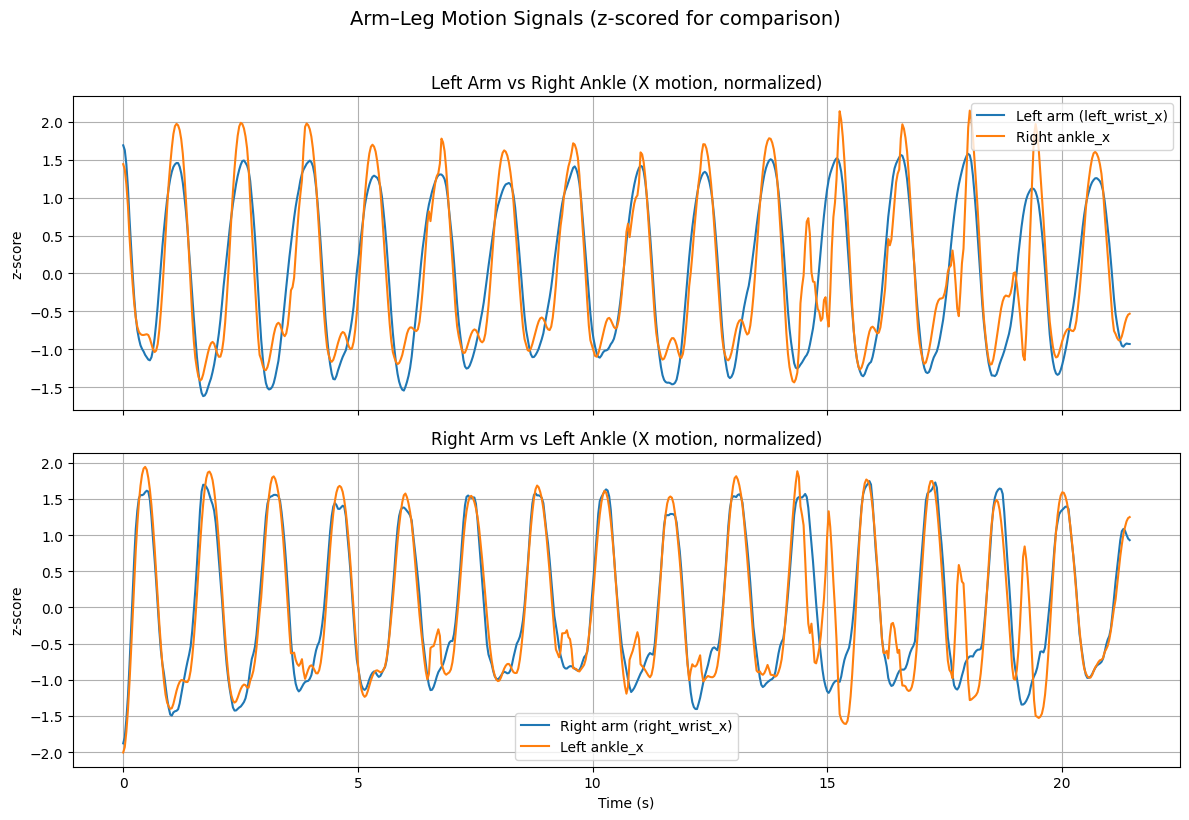

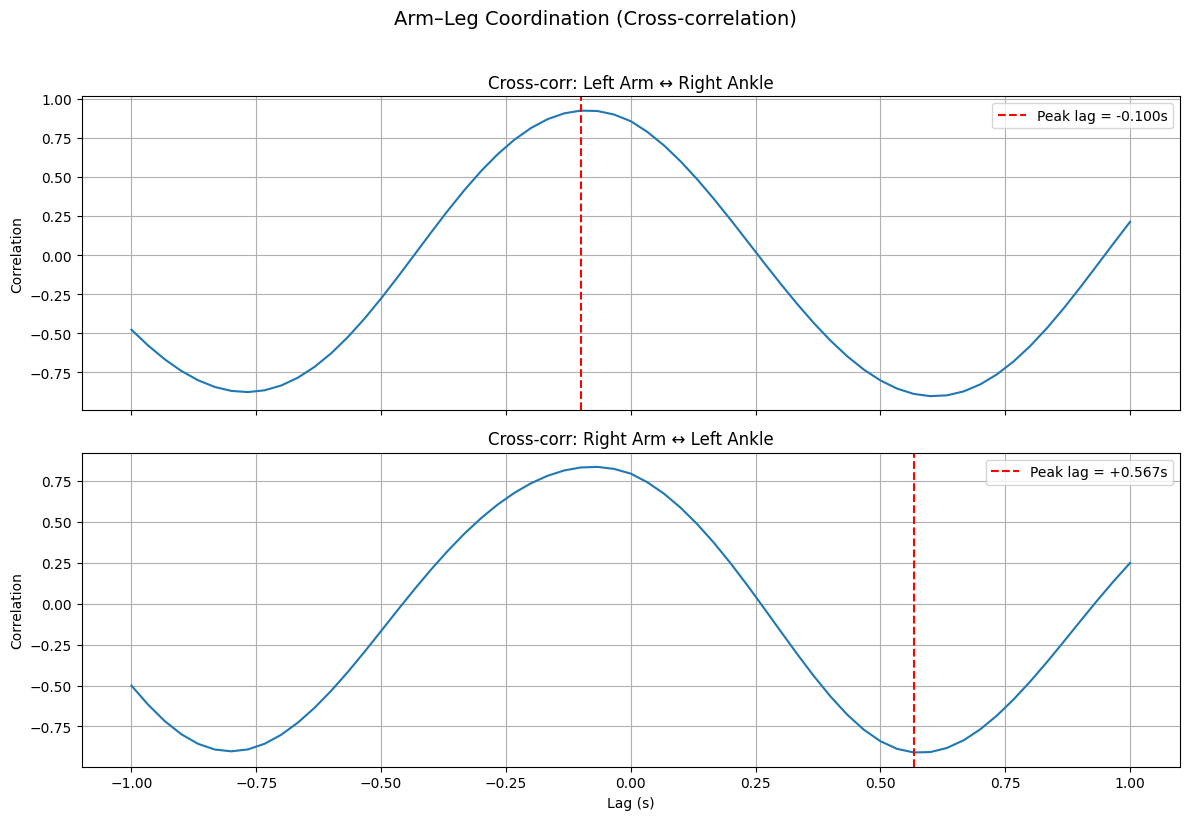


# 🏃 Arm–Leg Coordination Summary

- **Coupling strength**  
  - Left arm ↔ Right ankle: peak correlation = **0.92** at lag -0.100 s  
  - Right arm ↔ Left ankle: peak correlation = **-0.91** at lag +0.567 s  

- **Swing amplitudes (px)**  
  - Arms: L = 57.6, R = 68.9 → asymmetry = **-17.9%**  
  - Ankles: L = 181.2, R = 180.3 → asymmetry = **+0.5%**  

### 📝 Interpretation
- Correlations near 1 and lag ~0 → arms and legs move in sync (good coordination).  
- Large asymmetry (%) may indicate imbalance, fatigue, or technique issues.  
- Small ankle asymmetry (≈0–5%) is normal; larger arm asymmetry can affect running economy.  


In [12]:
# Arm–Leg coordination using ANKLE X (horizontal)
# - Left arm (wrist_x) vs Right ankle_x
# - Right arm (wrist_x) vs Left ankle_x
# - Cross-correlation lag + amplitudes + asymmetry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- config ----------
csv_path   = "metrics_2.csv"   # change if needed
target_hz  = 30              # resample rate (Hz)
max_lag_s  = 1.0             # search window for lags (± seconds)
smooth_win = 7               # moving average window (samples) for light smoothing
detrend_win = 31             # window for moving-average detrend (remove slow drift)

# ---------- helpers ----------
def pick_column(df, prefer, fallback):
    for c in prefer:
        if c in df.columns: return c
    for c in fallback:
        if c in df.columns: return c
    return None

def interp_uniform(t, y, hz):
    m = np.isfinite(t) & np.isfinite(y)
    t, y = t[m], y[m]
    if len(t) < 5: return None, None
    t0, t1 = float(t[0]), float(t[-1])
    n = max(5, int((t1 - t0) * hz))
    tu = np.linspace(t0, t1, n)
    yu = np.interp(tu, t, y)
    return tu, yu

def ma(y, k):
    if k <= 1: return y
    k = int(k)
    w = np.ones(k)/k
    pad = k//2
    ypad = np.pad(y, pad_width=pad, mode="reflect")
    return np.convolve(ypad, w, mode="valid")

def detrend_ma(y, k):
    # high-pass: remove slow drift (camera motion, translation)
    return y - ma(y, k)

def zscore(y):
    y = np.asarray(y, float)
    return (y - np.nanmean(y)) / (np.nanstd(y) + 1e-9)

def xcorr(y, x, max_lag_samples):
    # normalized cross-correlation → always between -1 and +1
    y = y - np.mean(y)
    x = x - np.mean(x)
    denom = (np.std(y) * np.std(x)) + 1e-12

    corr_full = np.correlate(y, x, mode="full") / denom
    corr_full /= len(y)  # normalize to [-1,1]

    lags = np.arange(-len(y)+1, len(y))
    mask = (lags >= -max_lag_samples) & (lags <= max_lag_samples)
    return lags[mask], corr_full[mask]


def p95_minus_p5(y):
    s = pd.Series(y).dropna()
    if s.empty: return np.nan
    return float(np.percentile(s, 95) - np.percentile(s, 5))

# ---------- load ----------
df = pd.read_csv(csv_path)
if "time_s" not in df.columns:
    raise ValueError("CSV must include 'time_s'.")

# arms: prefer wrist_x, fallback elbow_x
Larm_col = pick_column(df,
    ["left_wrist_x","left_index_x","left_pinky_x","left_thumb_x","left_elbow_x"],
    ["left_elbow_x"])
Rarm_col = pick_column(df,
    ["right_wrist_x","right_index_x","right_pinky_x","right_thumb_x","right_elbow_x"],
    ["right_elbow_x"])
if Larm_col is None or Rarm_col is None:
    raise ValueError("Missing left/right wrist_x (or elbow_x) columns.")

# ankles: x positions
if not {"left_ankle_x","right_ankle_x"}.issubset(df.columns):
    raise ValueError("CSV must include 'left_ankle_x' and 'right_ankle_x'.")

t = df["time_s"].to_numpy(float)
def resample_col(col): 
    return interp_uniform(t, df[col].to_numpy(float), target_hz)

tU, Lax = resample_col("left_ankle_x")
_,  Rax = resample_col("right_ankle_x")
_,  Lx  = resample_col(Larm_col)
_,  Rx  = resample_col(Rarm_col)


# smooth + detrend (remove slow camera drift / treadmill translation)
Lax_f = detrend_ma(ma(Lax, smooth_win), detrend_win)
Rax_f = detrend_ma(ma(Rax, smooth_win), detrend_win)
Lx_f  = detrend_ma(ma(Lx,  smooth_win), detrend_win)
Rx_f  = detrend_ma(ma(Rx,  smooth_win), detrend_win)

# z-score for correlation comparability
Larm  = zscore(Lx_f)
Rarm  = zscore(Rx_f)
Lank  = zscore(Lax_f)
Rank  = zscore(Rax_f)

# cross-correlations: Left arm vs Right ankle_x, Right arm vs Left ankle_x
max_lag_samples = int(max_lag_s * target_hz)
lags_LR, corr_LR = xcorr(Larm, Rank, max_lag_samples)
lags_RL, corr_RL = xcorr(Rarm, Lank, max_lag_samples)

iLR = int(np.argmax(np.abs(corr_LR)))
iRL = int(np.argmax(np.abs(corr_RL)))
lag_LR_s = lags_LR[iLR] / target_hz   # + means Left arm leads Right ankle
lag_RL_s = lags_RL[iRL] / target_hz   # + means Right arm leads Left ankle
r_LR = corr_LR[iLR]
r_RL = corr_RL[iRL]

# amplitudes (robust) and asymmetry
arm_amp_L = p95_minus_p5(Lx_f)
arm_amp_R = p95_minus_p5(Rx_f)
ank_amp_L = p95_minus_p5(Lax_f)
ank_amp_R = p95_minus_p5(Rax_f)
arm_amp_asym_pct = (arm_amp_L - arm_amp_R) / ((arm_amp_L + arm_amp_R)/2 + 1e-9) * 100.0
ank_amp_asym_pct = (ank_amp_L - ank_amp_R) / ((ank_amp_L + ank_amp_R)/2 + 1e-9) * 100.0

# --- Add knees: columns must exist in CSV ---
assert {"left_knee_x","right_knee_x"}.issubset(df.columns), "Need left_knee_x/right_knee_x"

# resample + filter knees
_, Lkx = interp_uniform(t, df["left_knee_x"].to_numpy(float),  target_hz)
_, Rkx = interp_uniform(t, df["right_knee_x"].to_numpy(float), target_hz)
Lkx_f = detrend_ma(ma(Lkx, smooth_win), detrend_win)
Rkx_f = detrend_ma(ma(Rkx, smooth_win), detrend_win)
Lknee  = zscore(Lkx_f)
Rknee  = zscore(Rkx_f)

# ---------- plots ----------
# 1) Motion signals (z-scored)
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].plot(tU, Larm, label=f"Left arm ({Larm_col})", lw=1.5)
ax[0].plot(tU, Rknee, label="Right ankle_x", lw=1.5)
ax[0].set_ylabel("z-score")
ax[0].set_title("Left Arm vs Right Ankle (X motion, normalized)")
ax[0].legend(); ax[0].grid(True)

ax[1].plot(tU, Rarm, label=f"Right arm ({Rarm_col})", lw=1.5)
ax[1].plot(tU, Lknee, label="Left ankle_x", lw=1.5)
ax[1].set_ylabel("z-score")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Right Arm vs Left Ankle (X motion, normalized)")
ax[1].legend(); ax[1].grid(True)

plt.suptitle("Arm–Leg Motion Signals (z-scored for comparison)", fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

# 2) Cross-correlation curves
lags_LR_s = lags_LR / target_hz
lags_RL_s = lags_RL / target_hz
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

ax[0].plot(lags_LR_s, corr_LR, lw=1.5)
ax[0].axvline(lag_LR_s, color="r", linestyle="--", label=f"Peak lag = {lag_LR_s:+.3f}s")
ax[0].set_ylabel("Correlation")
ax[0].set_title("Cross-corr: Left Arm ↔ Right Ankle")
ax[0].legend(); ax[0].grid(True)

ax[1].plot(lags_RL_s, corr_RL, lw=1.5)
ax[1].axvline(lag_RL_s, color="r", linestyle="--", label=f"Peak lag = {lag_RL_s:+.3f}s")
ax[1].set_ylabel("Correlation"); ax[1].set_xlabel("Lag (s)")
ax[1].set_title("Cross-corr: Right Arm ↔ Left Ankle")
ax[1].legend(); ax[1].grid(True)

plt.suptitle("Arm–Leg Coordination (Cross-correlation)", fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

# ---------- auto-summary (markdown-style) ----------

summary = f"""
# 🏃 Arm–Leg Coordination Summary

- **Coupling strength**  
  - Left arm ↔ Right ankle: peak correlation = **{r_LR:.2f}** at lag {lag_LR_s:+.3f} s  
  - Right arm ↔ Left ankle: peak correlation = **{r_RL:.2f}** at lag {lag_RL_s:+.3f} s  

- **Swing amplitudes (px)**  
  - Arms: L = {arm_amp_L:.1f}, R = {arm_amp_R:.1f} → asymmetry = **{arm_amp_asym_pct:+.1f}%**  
  - Ankles: L = {ank_amp_L:.1f}, R = {ank_amp_R:.1f} → asymmetry = **{ank_amp_asym_pct:+.1f}%**  

### 📝 Interpretation
- Correlations near 1 and lag ~0 → arms and legs move in sync (good coordination).  
- Large asymmetry (%) may indicate imbalance, fatigue, or technique issues.  
- Small ankle asymmetry (≈0–5%) is normal; larger arm asymmetry can affect running economy.  
"""

from IPython.display import Markdown, display
display(Markdown(summary))

